In [1]:
import sys
import os
import glob
from datetime import datetime
import re

import boto3
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset
from netCDF4 import MFDataset, num2date
from matplotlib import image

from cloudflow.services.S3Storage import S3Storage
from cloudflow.job.Plotting import Plotting
from cloudflow.utils import romsUtil as utils

DEBUG = False

In [2]:
def make_indexhtml(indexfile : str, imagelist : list):
    """ Creates a basic index.html file for displaying the images in imagelist """

    htmlhead = '''<html xmlns="http://www.w3.org/1999/xhtml">
                  <meta http-equiv="Cache-control" content="no-cache">
                  <head>
                  <title>Cloud-Sandbot</title>
                  </head>'''

    htmlbody = '<body>\n'
    for image in imagelist:
        imagehtml = f'<img src="{image}">\n'
        htmlbody += imagehtml

    htmlbody += '</body>\n'
    html = f'''{htmlhead}
               {htmlbody}
               </html>'''

    with open(indexfile, 'w') as index:
        index.write(html) 
        

In [3]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    """Load ROMS NOSOFS dataset"""

    filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')


In [4]:
def fvcom_nosofs(COMDIR: str, OFS: str, HH: str):
    """Load FVCOM NOSOFS dataset"""

    filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return MFDataset(filespec)


In [5]:
def dsofs_curr_fcst(COMROT: str='/com/nos'):
    """ Load the currently run OFS forecast on COMROT 
    This is almost the same as dosfs_newest, but will work better
    when running when injected in the regular workflow.
    It depends on a file being present in COMROT 'current.fcst'
    """
    
    cur_file = f'{COMROT}/current.fcst'
    
    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
#     fcst = 'cbofs.2020082500'
    
    print('fcst: ', fcst)
    
    COMDIR = f'{COMROT}/{fcst}'
    print('COMDIR: ', COMDIR)

    OFS = fcst.split('.')[0]
    fcstdate = fcst.split('.')[-1]
    HH = fcstdate[8:10]
    
    if DEBUG: # Only grab first 0-9 hours. Faster!
        filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    else: # Grab all hours
        filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
        
    print(f'filespec is: {filespec}')
    if OFS in utils.roms_models:
        return open_mfdataset(filespec, decode_times=False, combine='by_coords')
    elif OFS in utils.fvcom_models:
        return MFDataset(filespec)
    else:
        print(f"ERROR: model not recognized: {OFS}")
        return None

In [6]:
def plot_roms(ds, variable, s3upload=False) -> str:
    
    if variable == 'zeta':
        da = ds[variable].isel(ocean_time=1)
        cmap = cmocean.cm.phase
    if variable == 'temp':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.haline
    if variable == 'oxygen':
        da = ds[variable].isel(ocean_time=1, s_rho=0)
        cmap = cmocean.cm.oxy
    if variable == 'Pair':
        da = ds[variable].isel(ocean_time=1)
        cmap = cmocean.cm.diff
      
    # fig = plt.figure(figsize=(12,5))
    fig = plt.figure()
    ax = fig.add_axes([0, 0.1, 1, 1], projection=ccrs.PlateCarree())
    im = ax.contourf(da.lon_rho, da.lat_rho, da.values,
                     transform=ccrs.PlateCarree(), 
                     cmap=cmap)
    
    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);

    init = ds.ocean_time.isel(ocean_time=0)
    init_str = f"INIT: {num2date(init, init.units)}"
    valid = da.ocean_time
    valid_str = f"VALID: {num2date(valid, valid.units)}"
    
    datestrfmt = '%b %d, %Y %H:%M %Z' #'%Y-%m-%d %H:%M:%S'
    now_str = f"Image generated:\n{datetime.now().strftime(datestrfmt)}"
    
    title = ds.title
    ax.set_title(f'{title}\n{init_str}\n{valid_str}')
    
    cbar = fig.colorbar(im, ax=ax)
    long_name = da.attrs['long_name']
    if variable != 'salt':
        units = da.attrs['units']
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')
    
    indexfile = f'docs/index.html'
    outfile = f'docs/{variable}.png'
    
    img = image.imread('docs/rps_small.png')
    
    bbox = ax.get_position().bounds
    logo_axis = fig.add_axes([bbox[0], 0.0, 0.15, 0.075])
    logo_axis.imshow(img, interpolation='hanning')
    logo_axis.axis('off')
    
    datestrfmt = '%b %d, %Y %H:%M %Z' # https://docs.python.org/3/library/datetime.html#aware-and-naive-objects
    now_str = f"Image generated:\n{datetime.now().strftime(datestrfmt)}"
    fig.text(0.55, 0.0, f'{now_str}')
    
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    imagename = outfile.split('/')[-1]

    plt.savefig(outfile, bbox_inches='tight')
             
    if s3upload:
        s3 = S3Storage()
        bucket = 'ioos-cloud-www'
        bucket_folder = 'sandbot/'

        key = f'{bucket_folder}{variable}.png'
        s3.uploadFile(outfile, bucket, key, public=True)

    return imagename

In [7]:
def plot_fvcom(ds, variable, s3upload=False) -> str:

    time = 3
    siglay = 0
    dims = 2
    
    if variable == 'zeta':
        #zeta(time, node)
        dims = 2
        da = ds[variable]
        cmap = cmocean.cm.phase
    if variable == 'temp':
        #temp(time, siglay, node)
        dims = 3
        #da = ds[variable][:][siglay]
        da = ds.variables[variable]
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        #salinity(time, siglay, node)
        dims = 3
        da = ds['salinity']
        cmap = cmocean.cm.haline
    if variable == 'Pair':
        #atmos_press(time, node)
        dims = 2
        da = ds['atmos_press']
        cmap = cmocean.cm.diff
          
    fig = plt.figure()
#     fig = plt.figure(figsize=(12,5))
    ax = fig.add_axes([0, 0.1, 1, 1], projection=ccrs.PlateCarree())
    lon = ds['lon'][:]
    lon = np.where(lon > 180., lon-360., lon)
    lat = ds['lat'][:]
    #im = ax.contourf(lon, lat, da, transform=ccrs.PlateCarree(), cmap=cmap)
    #da needs to be 2 dimensional array x,y, but fvcom is single dimension node or nele
    #im = ax.contourf(da, cmap=cmap)
    nv = ds.variables['nv'][:].T
    nv = nv - 1

    #print(f"DEBUGGING: lon.len: {len(lon[:])}, da.len: {len(da[:])} ")
    if dims == 2:
        im = ax.tripcolor(lon, lat, nv, da[time], cmap=cmap)
    if dims == 3:
        im = ax.tripcolor(lon, lat, nv, da[time][siglay], cmap=cmap)

    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);
    
    
    title = ds.title
    time_array = ds.variables['time']
    init = time_array[0]
    init_str = f"INIT: {num2date(init, time_array.units)}"
    valid = time_array[time]
    valid_str = f"VALID: {num2date(valid, time_array.units)}"
    ax.set_title(f'{title}\n{init_str}\n{valid_str}')

    long_name = da.long_name
    cbar = fig.colorbar(im, ax=ax)
    if variable != 'salt':
        units = da.units
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')
        
    img = image.imread('docs/rps_small.png')
    bbox = ax.get_position().bounds
    logo_axis = fig.add_axes([bbox[0], 0.0, 0.15, 0.075])
    logo_axis.imshow(img, interpolation='hanning')
    logo_axis.axis('off')
        
        
    datestrfmt = '%b %d, %Y %H:%M %Z' #'%Y-%m-%d %H:%M:%S'
    now_str = f"Image generated:\n{datetime.now().strftime(datestrfmt)}"
    fig.text(0.55, 0.0, f'{now_str}')
    
        
    indexfile = f'docs/index.html'
    outfile = f'docs/{variable}.png'
    
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    imagename = outfile.split('/')[-1]

    plt.savefig(outfile, bbox_inches='tight')
             
    if s3upload:
        s3 = S3Storage()
        bucket = 'ioos-cloud-www'
        bucket_folder = 'sandbot/'

        key = f'{bucket_folder}{variable}.png'
        s3.uploadFile(outfile, bucket, key, public=True)

    return imagename


In [8]:
def get_model_type(ds) -> str:
    """ Determines and returns the model used to create the dataset if known. """
    
    # ROMS
    # "type: ROMS/TOMS history file"
    try:
        typestr = ds.attrs['type']
        if re.search('ROMS', typestr):
            return 'roms'
    except Exception as e:
        if DEBUG: print('Not ROMS data')
    
    # FVCOM
    # :source = "FVCOM_4.3"
    try:
        sourcestr = ds.source
        if re.search('FVCOM', sourcestr):
            return 'fvcom'
        print(f'sourcestr: {sourcestr}')
    except Exception as e:
        if DEBUG: print('Not FVCOM data')
        
    return 'unknown'

In [9]:
# Testing
def testing():

    ds = dsofs_curr_fcst()
    #ds
    get_model_type(ds)

    variable = 'salinity'
    variable = 'temp'
    #da = ds[temp][0][0]

    da = ds.variables[variable][0]
    # da is a numpy array
    print(da)

    da = ds.variables[variable]
    # da is a netcdf variable
    print(da)
    #print(da.long_name)


    nv = ds.variables['nv'][0][:] 
    nv = nv - 1
    print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")


    # THIS ONE DOESN'T CAUSE AN ERROR
    nv = ds.variables['nv'][:].T
    nv = nv - 1
    print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")
    ######################

    nv = ds.variables['nv'][0][:].T
    nv = nv - 1
    print(f"DEBUGGING - nv :  {nv}, len: {len(nv)}")

    ds.close()

In [10]:
def plot_runner(ds, variable, s3upload=False) -> str:
    """ Alternative implementation for running the appropriate plot routine based on the model type"""

    model_type = get_model_type(ds)
    if model_type == 'roms':
        imagename = plot_roms(ds_ofs, var, s3upload=True)
    elif model_type == 'fvcom':
        imagename = plot_fvcom(ds_ofs, var, s3upload=True)
    else:
        print(f"ERROR: Unsupported model type - {modeltype}")

In [11]:
def ofsname_curr(cur_file : str = '/com/nos/current.fcst') -> str:
    """ Determines and returns the forecast type in the current.fcst file"""

    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
    
    print('fcst: ', fcst)
    
    OFS = fcst.split('.')[0]
   
    return OFS

In [12]:
def main():
       
    ds_ofs = dsofs_curr_fcst()
    model = get_model_type(ds_ofs)
    print(model)
    
    indexfile = f'docs/index.html'
    if not os.path.exists('./docs'):
        os.makedirs('./docs')

    bucket = 'ioos-cloud-www'
    bucket_folder = 'sandbot/'

    storageService = S3Storage()

    plot_vars = ['temp', 'zeta', 'salt']
    #plot_vars = ['temp']

    imagelist = []
    
    if DEBUG:
        upload = False
    else:
        upload = True
        
    for var in plot_vars:
        #imagename = plot_runner(ds_ofs, var, s3upload=upload)
        if model == 'roms':
            imagename = plot_roms(ds_ofs, var, s3upload=upload)
        elif model == 'fvcom':
            imagename = plot_fvcom(ds_ofs, var, s3upload=upload)
        else:
            print('ERROR: model not supported')
            raise Exception(e)

        imagelist.append(imagename)

    if upload:
        make_indexhtml(indexfile, imagelist)
        storageService.uploadFile(indexfile, bucket, f'{bucket_folder}index.html', public=True, text=True)
    
    print('Finished ...')

fcst:  sfbofs.2020081803
COMDIR:  /com/nos/sfbofs.2020081803
filespec is: /com/nos/sfbofs.2020081803/nos.sfbofs.fields.f*.t03z.nc
Not ROMS
fvcom
Finished ...


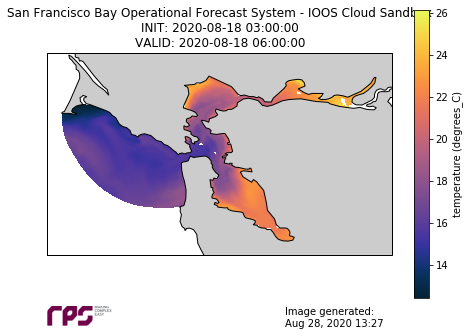

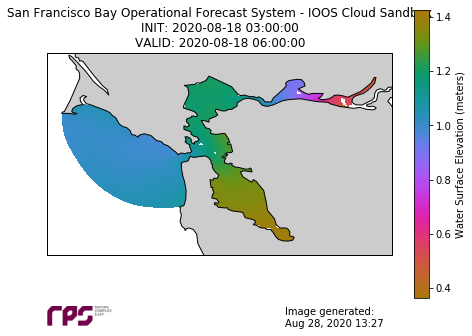

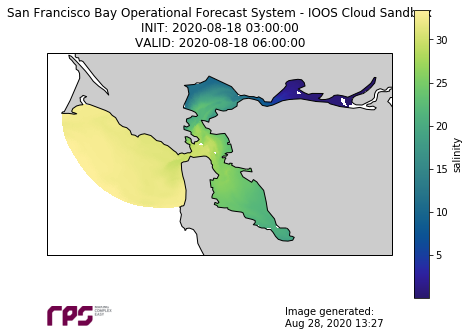

In [13]:
main()
#testing()

In [14]:
from cloudflow.workflows import flows

flows.inject_notebook()

[2020-08-28 13:27:53,437] INFO - flow_runner.run | Beginning Flow run for 'notebook test'
[2020-08-28 13:27:53,443] INFO - flow_runner.set_flow_to_running | Starting flow run.
[2020-08-28 13:27:53,469] INFO - task_runner.run | Task 'run_pynotebook': Starting task run...


 2020-08-28 13:27:53,470  INFO - tasks.run_pynotebook | Running sandbot_current_fcst.py


fcst:  sfbofs.2020081803
COMDIR:  /com/nos/sfbofs.2020081803
filespec is: /com/nos/sfbofs.2020081803/nos.sfbofs.fields.f00*.t03z.nc
Not ROMS
fvcom
Finished ...

[2020-08-28 13:28:08,834] INFO - task_runner.run | Task 'run_pynotebook': finished task run for task with final state: 'Success'
[2020-08-28 13:28:08,836] INFO - flow_runner.determine_final_state | Flow run SUCCESS: all reference tasks succeeded


'PASSED'